### **Contour-based approach:**
- Get 2 images (RGB reference image red misaligned image) <br>
- Get contour of both images <br>
- Match keypoints through shape match <br>
- Select best set of 3 points in both images through exhaustive search <br> 
- Get Affine transformation matrix from points<br>

###  **Dependencies:**

In [35]:
import cv2
import numpy as np
import pandas as pd
import more_itertools
from PIL import Image
from matplotlib import pyplot as plt
from IPython.display import clear_output

import warnings
warnings.filterwarnings('ignore')

### **Read images from file through dataframe referencing:**

In [36]:
df = pd.read_pickle("master_manifest_train_red.pkl")
print(len(df),'\n')
print(df.keys(),'\n')
df.drop('survey_id',axis=1,inplace=True)
df.head()

103 

Index(['anchor_image_path', 'ref_image_path', 'survey_id', 'target_image_path',
       'transform'],
      dtype='object') 



,anchor_image_path,ref_image_path,target_image_path,transform
0,survey_8502/target/aligned/red/tile__0.npy,survey_8502/reference/tile__0.npy,survey_8502/target/misaligned/red/tile__0.npy,"(0.9549864530563354, 0.0, 0.0, 0.0, 0.95338803..."
1,survey_8502/target/aligned/red/tile__1.npy,survey_8502/reference/tile__1.npy,survey_8502/target/misaligned/red/tile__1.npy,"(0.9549864530563354, 0.0, 0.0, 0.0, 0.95338803..."
2,survey_8502/target/aligned/red/tile__2.npy,survey_8502/reference/tile__2.npy,survey_8502/target/misaligned/red/tile__2.npy,"(0.9549864530563354, 0.0, 0.0, 0.0, 0.95338803..."
3,survey_8502/target/aligned/red/tile__3.npy,survey_8502/reference/tile__3.npy,survey_8502/target/misaligned/red/tile__3.npy,"(0.9549864530563354, 0.0, 0.0, 0.0, 0.95338803..."
4,survey_8502/target/aligned/red/tile__4.npy,survey_8502/reference/tile__4.npy,survey_8502/target/misaligned/red/tile__4.npy,"(0.9549864530563354, 0.0, 0.0, 0.0, 0.95338803..."


In [37]:
# Choose an instance:
i = 0

# Get misaligned image:
I = np.load(df.values[i][2])[0]
I = cv2.normalize(I, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
image_mis = I.astype(np.uint8)
rows,cols = image_mis.shape

# Get reference image (use the red channel):
I = np.load(df.values[i][1])[0][:,:,0]
I = cv2.normalize(I, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
im = Image.fromarray(I.astype(np.uint8))
image_ref = np.array(im.resize((cols,rows)))

#### **Contour detection:**

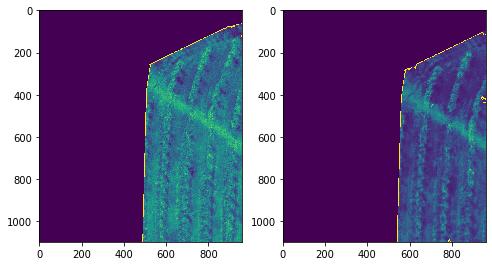

In [38]:
def Get_Contour_Features(I):
    I = cv2.normalize(I, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    I = I.astype(np.uint8)
    ret, thresh = cv2.threshold(I, 25, 255, 0)
    contours,hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contour = []
    for cont in contours:
        if len(cont) > 500: # drop all detected small contours
            contour.append(cont)
    cv2.drawContours(I, contour, -1, (255, 255, 255), 2)
    return I,contour,hierarchy

I1,contour1,hierarchy1 = Get_Contour_Features(image_ref)
I2,contour2,hierarchy2 = Get_Contour_Features(image_mis)

plt.figure(figsize=(8,10))
plt.subplot(121)
plt.imshow(I1)
plt.subplot(122)
plt.imshow(I2)
plt.show()

#### **Match the contours:**

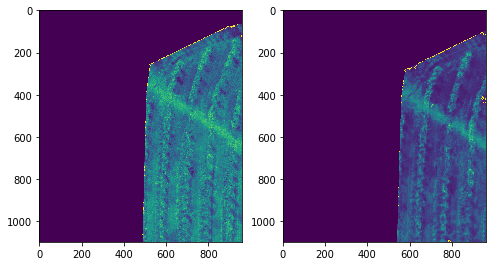

In [39]:
image1 = image_ref
image2 = image_mis

j = 0
ret = []

if (len(contour1[0]) != len(contour2[0])):
    if len(contour1[0]) > len(contour2[0]):
        start = len(contour2[0])
        end = len(contour1[0])
    else:
        start = len(contour1[0])
        end = len(contour2[0])
    for i in range(start,end): 
        ret.append(cv2.matchShapes(contour1[0][j:len(contour2[0])+j],contour2[0],cv2.CONTOURS_MATCH_I1,0))
        j += 1
indx = ret.index(min(ret))
pts1 = np.array(contour1[0][indx:len(contour2[0])+indx]) 
pts2 = np.array(contour2[0])

cv2.drawContours(image1, pts1, -1, (255, 255, 255), 2)
cv2.drawContours(image2, pts2, -1, (255, 255, 255), 2)

plt.figure(figsize=(8,10))
plt.subplot(121)
plt.imshow(image1)
plt.subplot(122)
plt.imshow(image2)
plt.show()

### **Search Affine transformation matrix:**

In [40]:
# Get all combinations of 3 points (the indexes) from the list of key points:

list_pts1 = []
for i in range(0,len(pts1),10):
    list_pts1.append(pts1[i])
Arr = np.array(list_pts1) 
list_pts1 = list(np.unique(Arr,axis=1)) 

list_pts2 = []
for i in range(0,len(pts2),10):
    list_pts2.append(pts2[i])
Arr = np.array(list_pts2) 
list_pts2 = list(np.unique(Arr,axis=1)) 

List = range(len(list_pts1))
list_comb1 = list(more_itertools.distinct_combinations(List, 3))

Index = []
for i in range(0,len(list_comb1),600):
    for j in range(0,len(list_comb1),600):
        Index.append([list_comb1[i],list_comb1[j]])

In [42]:
# Search best affine transform according to the correlation coefficient:
Max = 0
rows,cols = image1.shape
for i in range(len(Index)):
    Points1 = np.array([list_pts1[Index[i][0][j]][0] for j in range(3)],np.float32)
    Points2 = np.array([list_pts2[Index[i][0][j]][0] for j in range(3)],np.float32)
    M = cv2.getAffineTransform(Points1,Points2)
    reg_image = cv2.warpAffine(image2,M,(cols,rows))
    Corr = np.corrcoef(reg_image.flat, image1.flat)[0,1]
    if Corr > Max:
        Max = Corr
        Final_Trans = M
reg_image = cv2.warpAffine(image2,Final_Trans,(cols,rows))

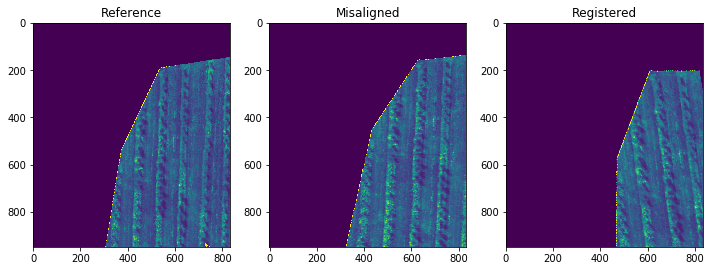

In [34]:
plt.figure(figsize=(12,18))
plt.subplot(131),plt.imshow(image1),plt.title('Reference')
plt.subplot(132),plt.imshow(image2),plt.title('Misaligned')
plt.subplot(133),plt.imshow(reg_image),plt.title('Registered')
plt.show()

#### **Similarality measures before and after registration:**

In [45]:
print('Transformation matrix:')
print(Final_Trans,'\n')

Corr = np.corrcoef(image_mis.flat, image_ref.flat)[0,1]
print('Compare reference with misaligned (with correlation coefficient):')
print("Correlation coefficient: {}".format(Corr),'\n')

Corr1 = np.corrcoef(reg_image.flat,image_ref.flat)[0,1]
print('Compare reference with registered (with correlation coefficient):')
print("Correlation coefficient: {}".format(Corr1))

Transformation matrix:
[[   1.05212453    0.22254335  -88.75362539]
 [   0.1469425     1.35693642 -105.18094007]] 

Compare reference with misaligned (with correlation coefficient):
Correlation coefficient: 0.7394746851286808 

Compare reference with registered (with correlation coefficient):
Correlation coefficient: 0.5895277548173691
